In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahaboelkhair/heartbeat-sound")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'heartbeat-sound' dataset.
Path to dataset files: /kaggle/input/heartbeat-sound


# **Heartbeat sounds**

Heart sounds are produced from a
specific cardiac event such as closure of
a valve or tensing of a chordae
tendineae.

• S1 result from the closing of the mitral
and tricuspid valves.

• S2 produced by the closure of the aortic
and pulmonic valves.

In medicine we call the ‘lub’
sound "S1" and the ‘dub’ sound
"S2".

You can learn short intro about heart sounds from this video:

https://www.youtube.com/watch?v=dBwr2GZCmQM

# About data:

Is challenge published in 2012 to classify the heart sound to some categories from ‘AISTATS’ .
Data has been gathered from two sources (A) and (B).

A) from the general public via the iStethoscope Pro.

B) from a clinic trial in hospitals using the digital stethoscope DigiScope.

Before we work on this nootebook we handle the data folders and conctante both sources(A&B) to be easy to deal with it.

Original Data here: http://www.peterjbentley.com/heartchallenge/

# Import main libraries

In [4]:
import os
import glob
import fnmatch
import pandas as pd
import numpy as np
import librosa #To deal with Audio files
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd
import math
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import concatenate

from tensorflow.keras.models import Sequential, Model, load_model

from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv1D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Input, add, Flatten, Dense, BatchNormalization, Dropout, LSTM, GRU
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalMaxPooling2D, Activation, LeakyReLU, ReLU

from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import cohen_kappa_score,roc_auc_score,confusion_matrix,classification_report

In [7]:
data_path = "/kaggle/input/heartbeat-sound/Heartbeat_Sound"
print(os.listdir(data_path))

['artifact', 'unlabel', 'extrastole', 'extrahls', 'normal', 'murmur']


In [8]:
tarin_data      = data_path
unlabel_data    = data_path  + "/unlabel/"

normal_data     = tarin_data + '/normal/'
murmur_data     = tarin_data + '/murmur/'
extrastole_data = tarin_data + '/extrastole/'
artifact_data   = tarin_data + '/artifact/'
extrahls_data   = tarin_data + "/extrahls/"

In [9]:
print("Normal files:", len(os.listdir(normal_data))) #length of normal training sounds
print("Murmur files:",len(os.listdir(murmur_data))) #length of murmur training sounds
print("Extrastole files", len(os.listdir(extrastole_data))) #length of extrastole training sounds
print("Artifact files:",len(os.listdir(artifact_data))) #length of artifact training sounds
print("Extrahls files:",len(os.listdir(extrahls_data))) #length of extrahls training sounds

print('TOTAL TRAIN SOUNDS:', len(os.listdir(normal_data))
                              + len(os.listdir(murmur_data))
                              + len(os.listdir(extrastole_data))
                              + len(os.listdir(artifact_data))
                              + len(os.listdir(extrahls_data)))

Normal files: 351
Murmur files: 129
Extrastole files 46
Artifact files: 40
Extrahls files: 19
TOTAL TRAIN SOUNDS: 585


In [10]:
print("Test sounds: ", len(os.listdir(unlabel_data)))

Test sounds:  247


# EDA and Visualization

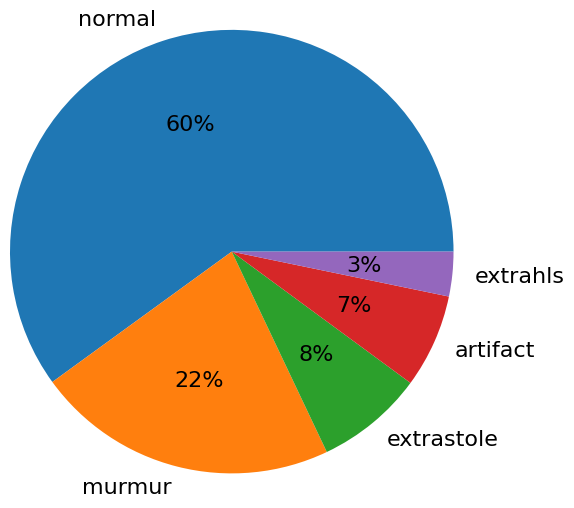

In [11]:
x = np.array([len(os.listdir(normal_data)),
              len(os.listdir(murmur_data)),
              len(os.listdir(extrastole_data)),
              len(os.listdir(artifact_data)),
              len(os.listdir(extrahls_data))])
labels = ['normal', 'murmur', 'extrastole', 'artifact', 'extrahls']
plt.pie(x, labels = labels, autopct = '%.0f%%', radius= 1.5, textprops={'fontsize': 16})
plt.show()

##### The figure shows imbalanced data so we need to fix it later


In [12]:
# Listen to rondom audio from specific class
def random_sound (audio_class):
    random_sound = np.random.randint(0,len(os.listdir(audio_class)))
    sound = os.listdir(audio_class)[random_sound]
    sound = audio_class+sound
    sound,sample_rate = librosa.load(sound)
    return ipd.Audio(sound,rate=sample_rate),sound

### Waveform

Sound is the pressure of air propagates to our ear. Digital audio file is gotten from a sound sensor that can detects sound waves and converting it to electrical signals.
Specifically, it's telling us about the wave's displacement, and how it changes over time.



X axis, represents time.
Y-axis measures displacement of air molecules.This is where amplitude comes in. It measures how much a molecule is displaced from its resting position.  

In [18]:
# show waveform of audio from dataset
# X axis, represents time.
# Y-axis measures displacement of air molecules.
# This is where amplitude comes in. It measures how much a molecule is displaced from its resting position.
def show_audio_waveform(audio_sample):
    plt.figure(figsize=(20,5))
    librosa.display.waveshow(audio_sample, sr=22050)
    plt.title("Sound")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

### Spectrum

A sound spectrum is a representation of a sound – usually a short sample of a sound – in terms of the amount of vibration at each individual frequency. It is usually presented as a graph of either power or pressure as a function of frequency. The power or pressure is usually measured in decibels and the frequency is measured in vibrations per second (or hertz, abbreviation Hz) or thousands of vibrations per second (kilohertz, abbreviation kHz).

The spectrum expresses the frequency composition of the sound and is obtained by analyzing the sound. A sound spectrum is usually represented in a coordinate plane where the frequency f is plotted along the axis of abscissas and the amplitude A, or intensity, of a harmonic component with a given frequency is plotted along the axis of ordinates.

In [14]:
# show spectrum of audio from dataset
def show_audio_spectrum(audio_sample):
    sample_rate = 22050
    fft_normal = np.fft.fft(audio_sample)
    magnitude_normal = np.abs(fft_normal)
    freq_normal = np.linspace(0,sample_rate, len(magnitude_normal))
    half_freq = freq_normal[:int(len(freq_normal)/2)]
    half_magnitude = magnitude_normal[:int(len(freq_normal)/2)]

    plt.figure(figsize=(12,8))
    plt.plot(half_freq,half_magnitude)
    plt.title("Spectrum")
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.show()

### Spectogram

For us, as human, we sense a sound not only on a particular time by its intensity, but also by its pitch. The pitch is the frequency of the sound - higher pitch corresponding to higher frequency and vice versa. So, to have a representation which is closer to our brain, we can add another dimension - the frequency - to our representation, which is the Spectrogram.

A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. When applied to an audio signal, spectrograms are sometimes called sonographs, voiceprints, or voicegrams.

Spectrograms are used extensively in the fields of music, linguistics, sonar, radar, speech processing,seismology, and others. Spectrograms of audio can be used to identify spoken words phonetically, and to analyse the various calls of animals.it can be generated by an optical spectrometer, a bank of band-pass filters, by Fourier transform or by a wavelet transform.

In [15]:
# show specrogram of audio from dataset
# the output is an image that represents a sound.
# X-axis is for time, y-axis is for frequency and the color is for intensity
def show_spectrogram (audio_sample):
    # STFT -> spectrogram
    hop_length = 512 # in num. of samples
    n_fft = 2048 # window in num. of samples
    sample_rate = 22050

    # calculate duration hop length and window in seconds
    hop_length_duration = float(hop_length)/sample_rate
    n_fft_duration = float(n_fft)/sample_rate

    print("STFT hop length duration is: {}s".format(hop_length_duration))
    print("STFT window duration is: {}s".format(n_fft_duration))

    # perform stft
    stft_normal = librosa.stft(audio_sample, n_fft=n_fft, hop_length=hop_length)

    # calculate abs values on complex numbers to get magnitude
    spectrogram = np.abs(stft_normal)
    log_spectrogram = librosa.amplitude_to_db(spectrogram)

    # display spectrogram
    plt.figure(figsize=(15,10))
    librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar()
    #plt.set_cmap("YlOrBr")
    plt.title("Spectrogram")

### MFCCs

We can’t take the raw audio signal as input to our model because there will be a lot of noise in the audio signal. It is observed that extracting features from the audio signal and using it as input to the base model will produce much better performance than directly considering raw audio signal as input. MFCC is the widely used technique for extracting the features from the audio signal.

in sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal spectrum. This frequency warping can allow for better representation of sound, for example, in audio compression.

**MFCCs are commonly derived as follows:**

1- Take the Fourier transform of (a windowed excerpt of) a signal.

2- Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows or alternatively, cosine overlapping windows.

3- Take the logs of the powers at each of the mel frequencies.

4- Take the discrete cosine transform of the list of mel log powers, as if it were a signal.

5- The MFCCs are the amplitudes of the resulting spectrum.

In [23]:
# MFCCs
# extract 52 MFCCs
def show_mfcc_features(audio_sample):
    hop_length = 512
    n_fft = 2048
    sample_rate = 22050

    MFCCs = librosa.feature.mfcc(
        y=audio_sample,
        sr=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mfcc=52
    )

    plt.figure(figsize=(15,10))
    librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("MFCC coefficients")
    plt.colorbar()
    plt.title("MFCCs")
    plt.show()


##  Dataset Classes

### *1. Normal*

Most normal heart rates at rest
will be between about 60 and
100 beats (‘lub dub’s) per
minute.

In [17]:
normal_audio, normal_sample  = random_sound(normal_data)
normal_audio

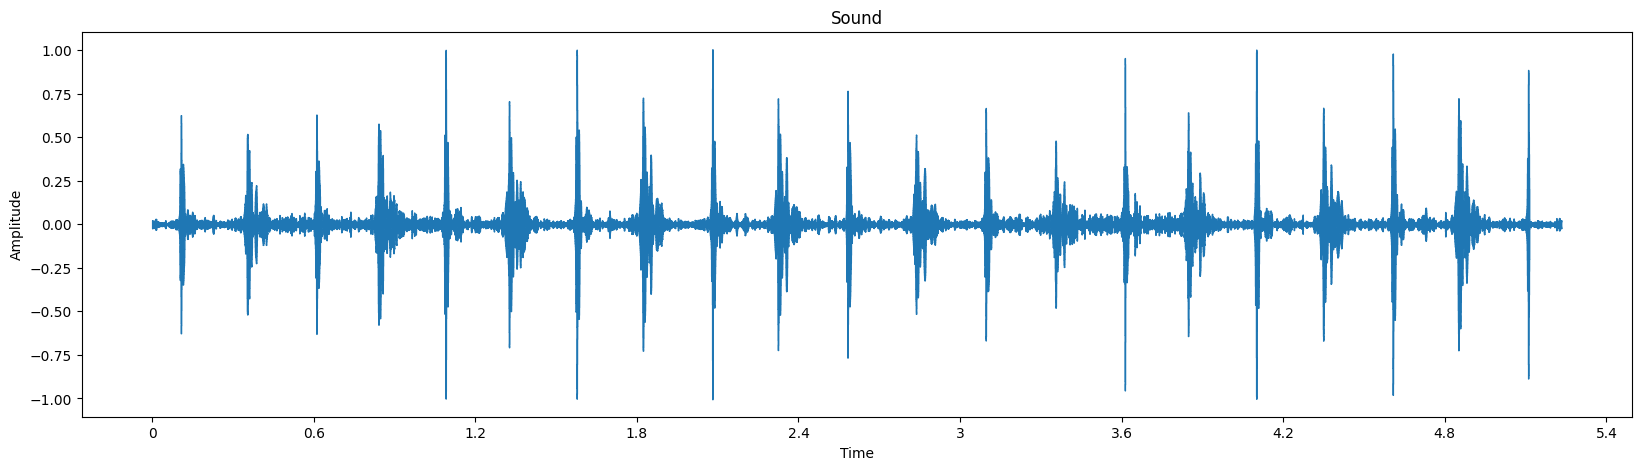

In [19]:
show_audio_waveform(normal_sample)

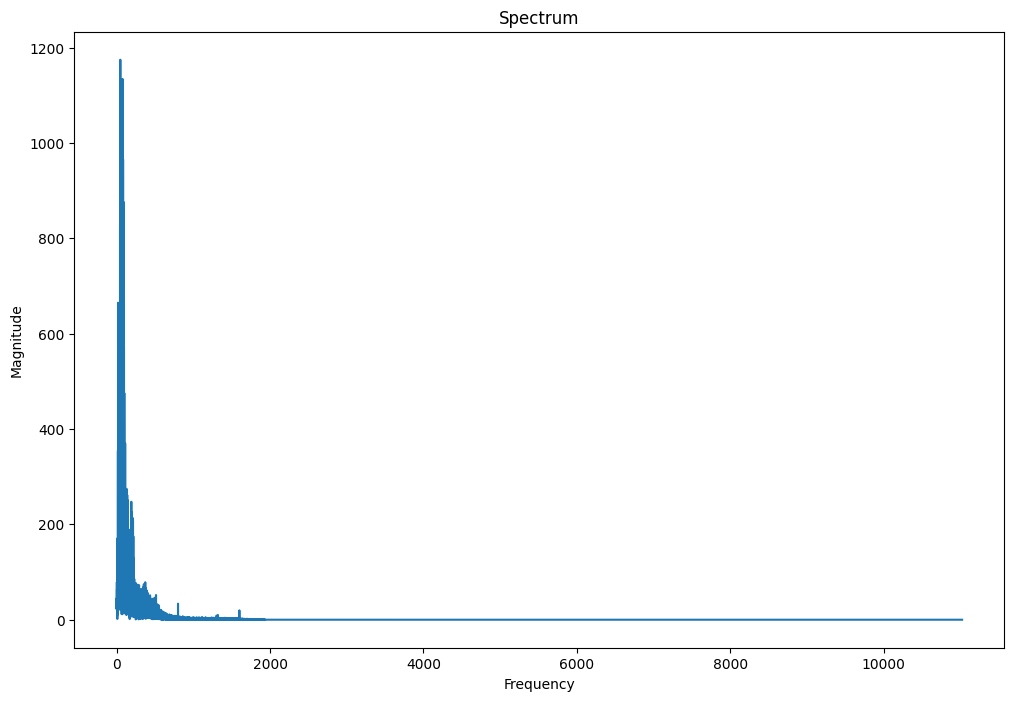

In [20]:
show_audio_spectrum(normal_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


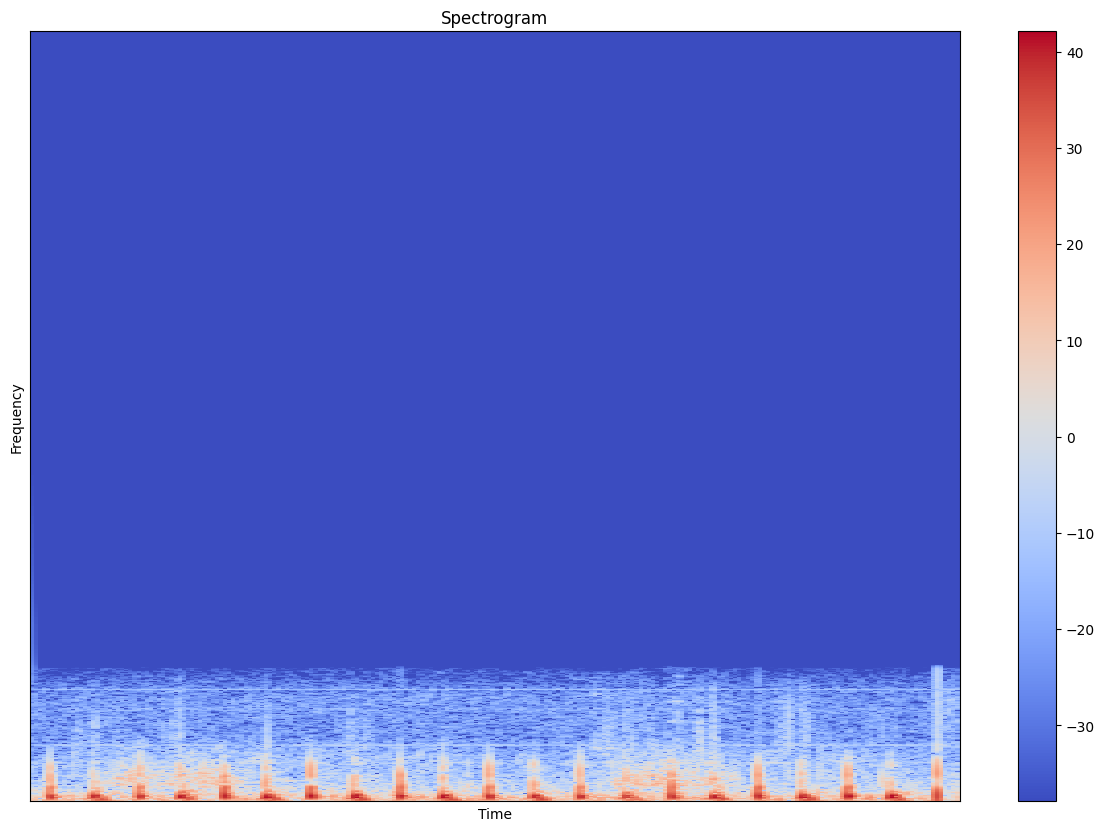

In [21]:
show_spectrogram(normal_sample)

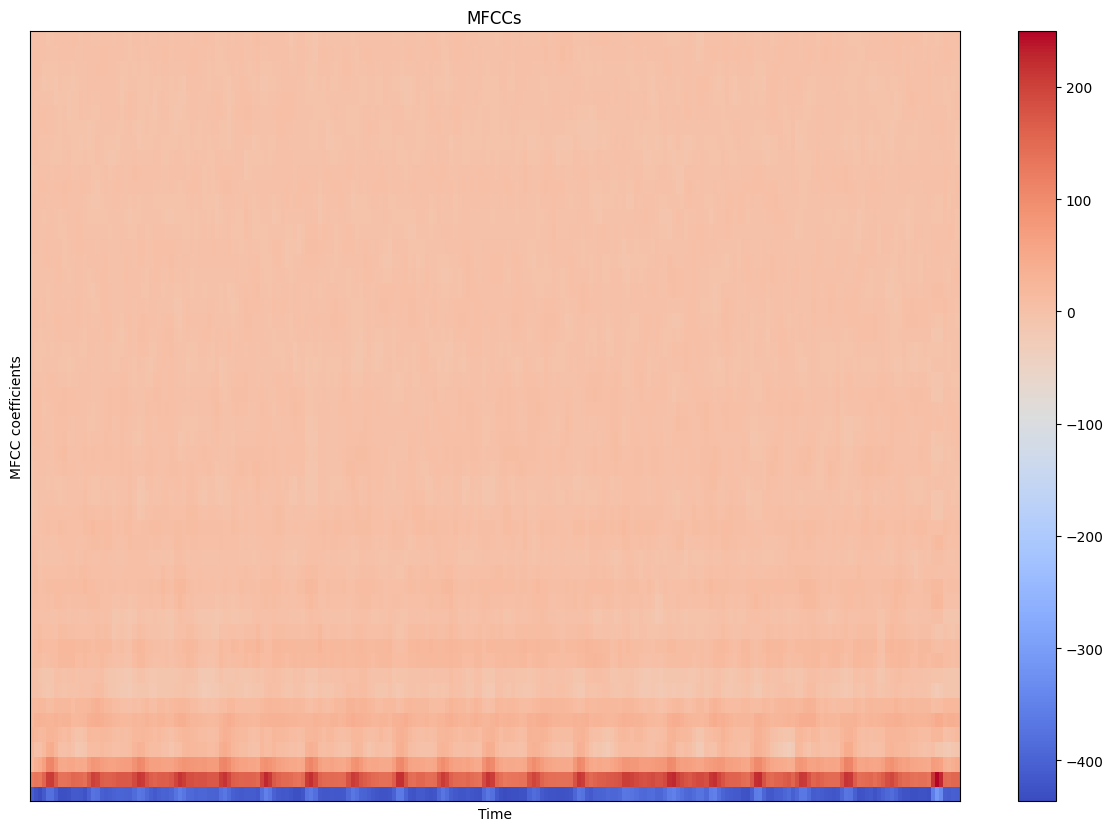

In [24]:
show_mfcc_features(normal_sample)

### *2. Murmur sound*

Heart murmurs sound as though there
is a “whooshing, roaring, rumbling, or
turbulent fluid” noise in one of two
temporal locations: (1) between “lub”
and “dub”, or (2) between “dub” and
“lub”. They can be a symptom of many
heart disorders, some serious.

In [25]:
murmur_audio, murmur_sample  = random_sound(murmur_data)
murmur_audio

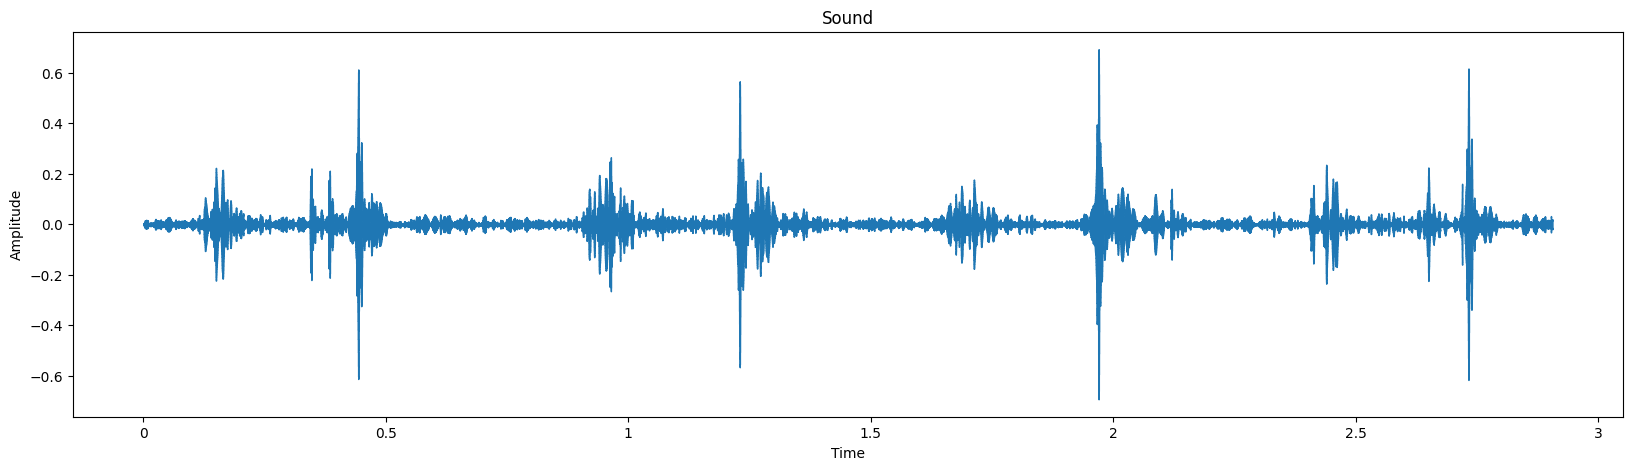

In [26]:
show_audio_waveform(murmur_sample)

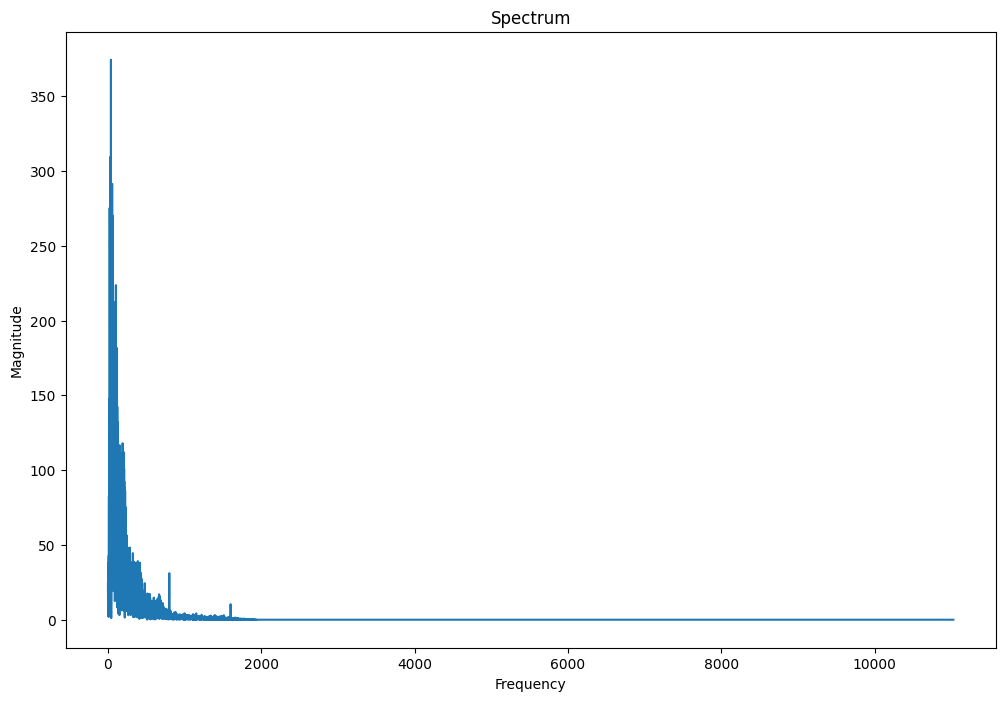

In [27]:
show_audio_spectrum(murmur_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


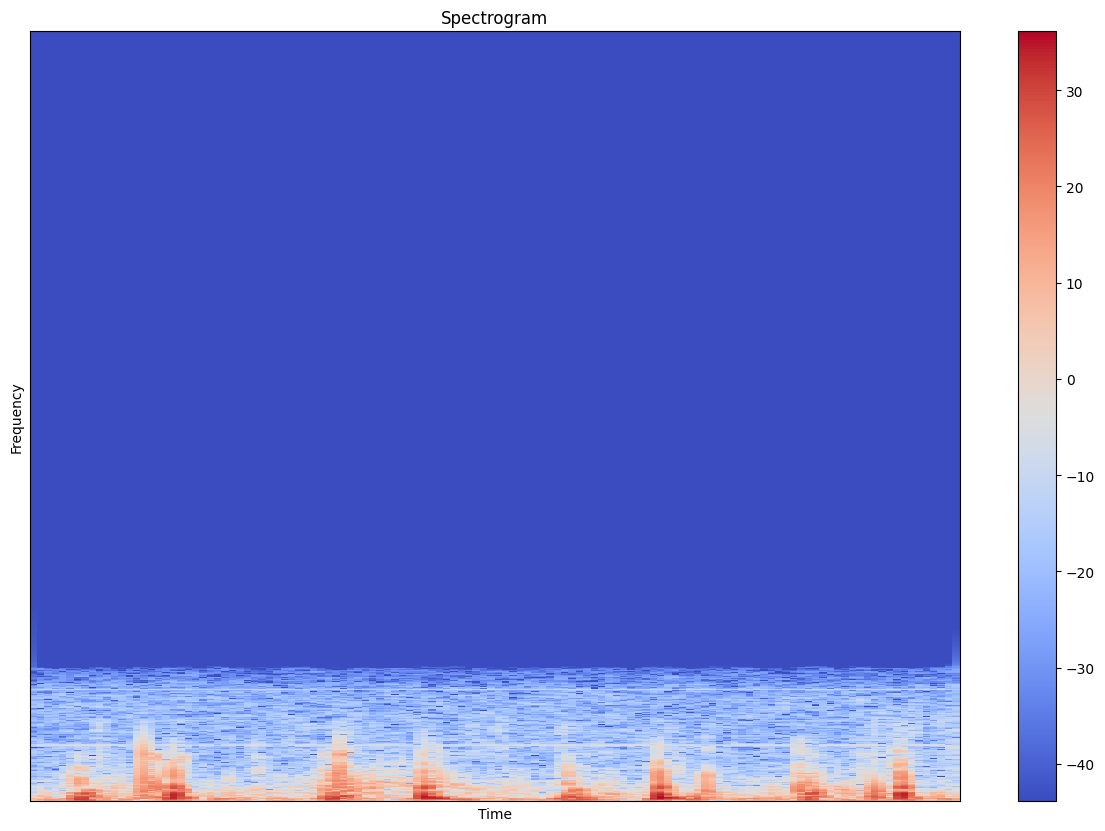

In [28]:
show_spectrogram(murmur_sample)

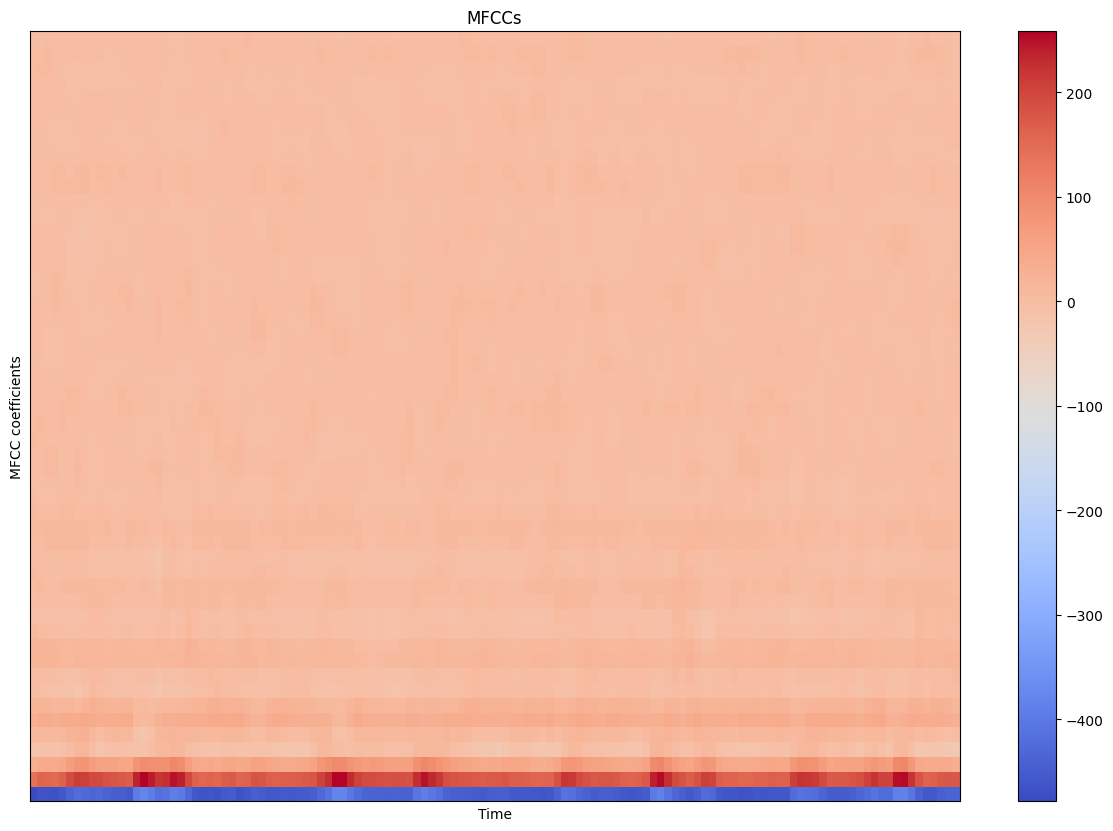

In [29]:
show_mfcc_features(murmur_sample)

### *3. Extrastole sound*

• Extrasystole sounds may appear occasionally and can be
identified because there is a heart sound that is out of rhythm
involving extra or skipped heartbeats, e.g. a “lub-lub dub” or a
“lub dub-dub”.

In [30]:
extrastole_audio, extrastole_sample  = random_sound(extrastole_data)
extrastole_audio

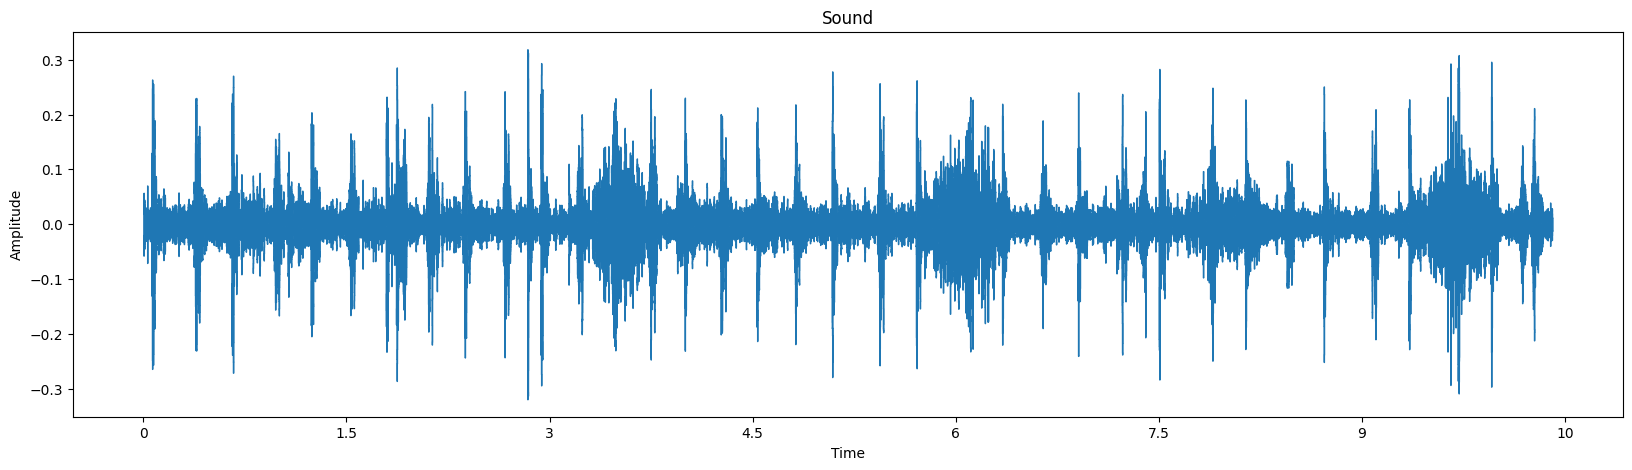

In [31]:
show_audio_waveform(extrastole_sample)

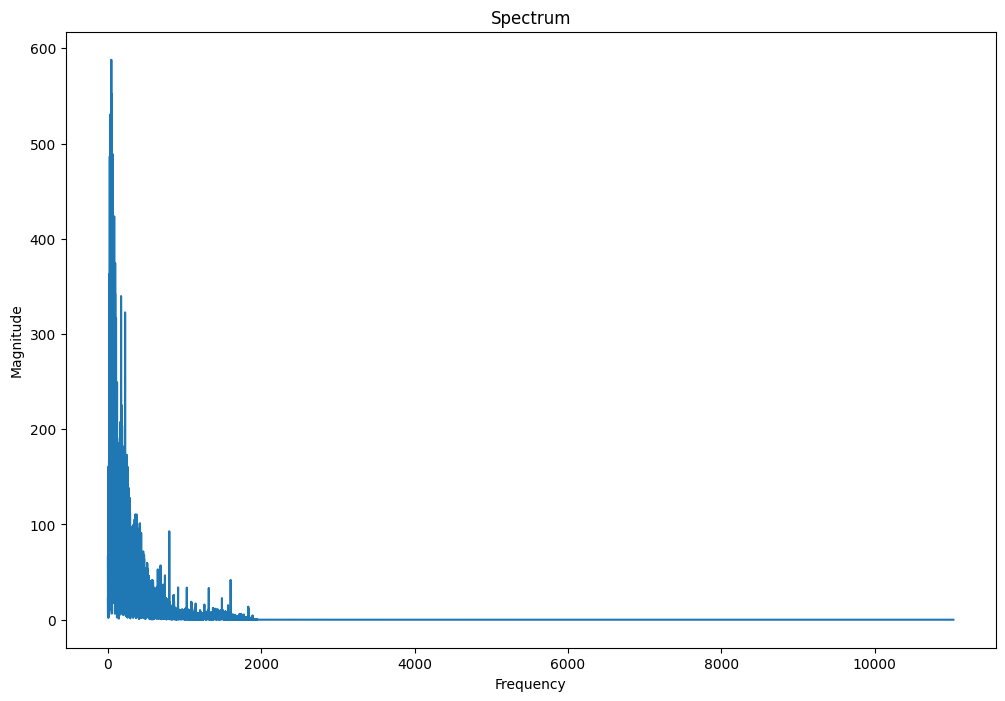

In [32]:
show_audio_spectrum(extrastole_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


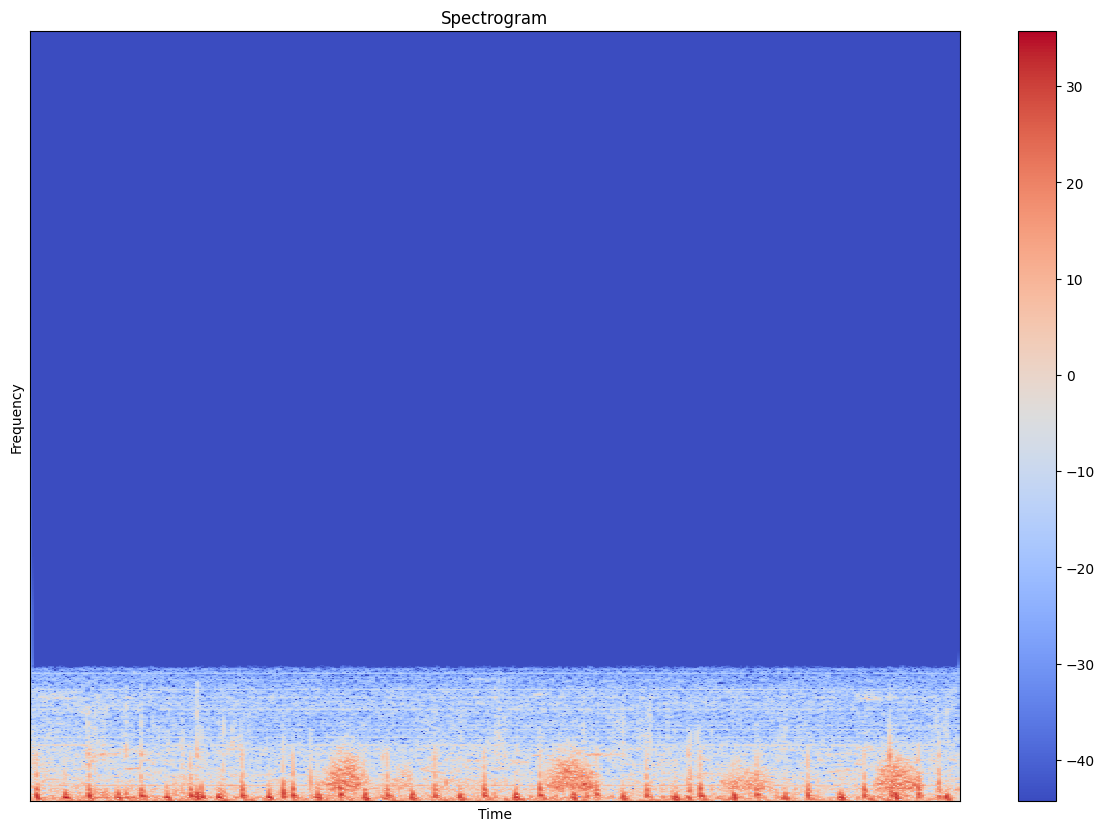

In [33]:
show_spectrogram(extrastole_sample)

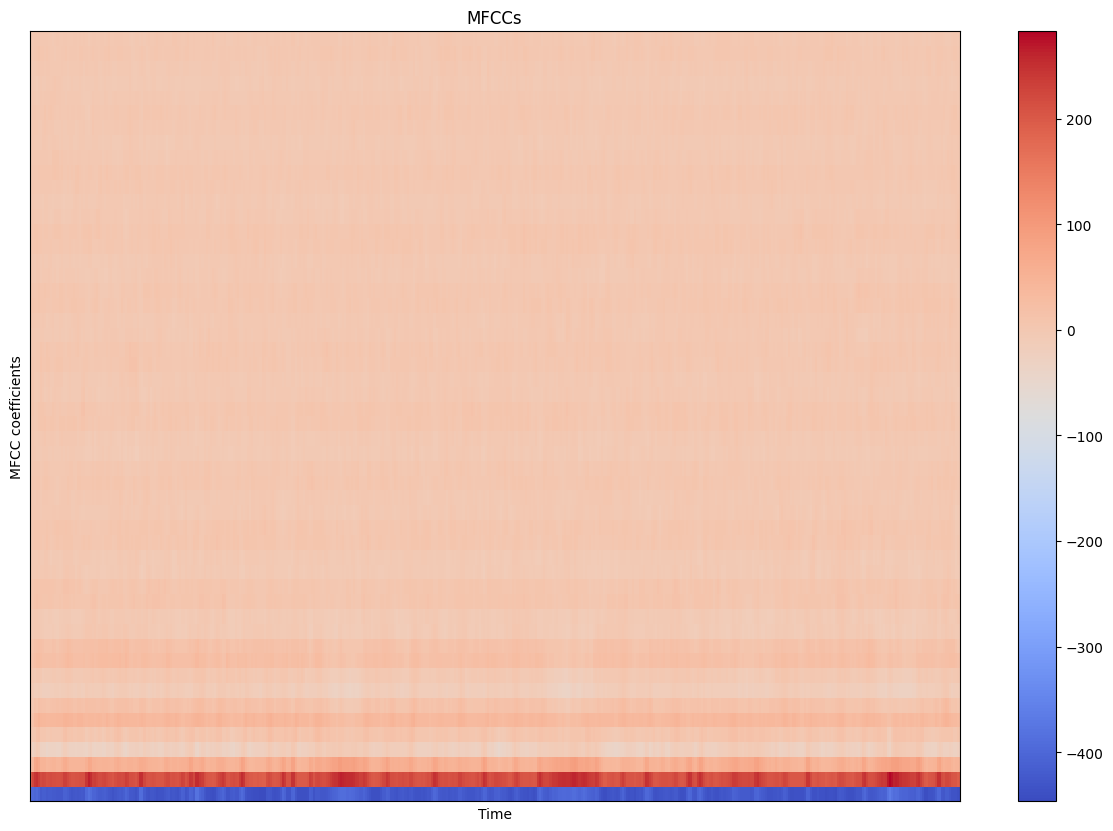

In [34]:
show_mfcc_features(extrastole_sample)

### *4. Artifact sound*

• In the Artifact category there are a wide range of different
sounds, including feedback squeals and echoes, speech, music
and noise.

In [35]:
artifact_audio, artifact_sample  = random_sound(artifact_data)
artifact_audio

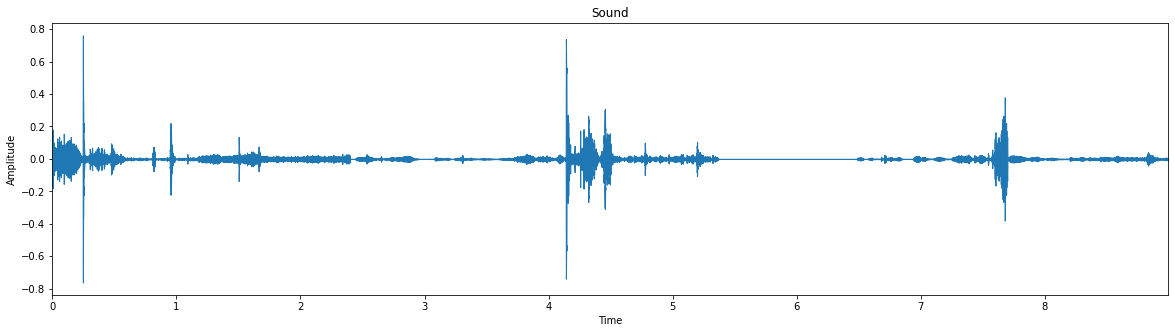

In [ ]:
show_audio_waveform(artifact_sample)

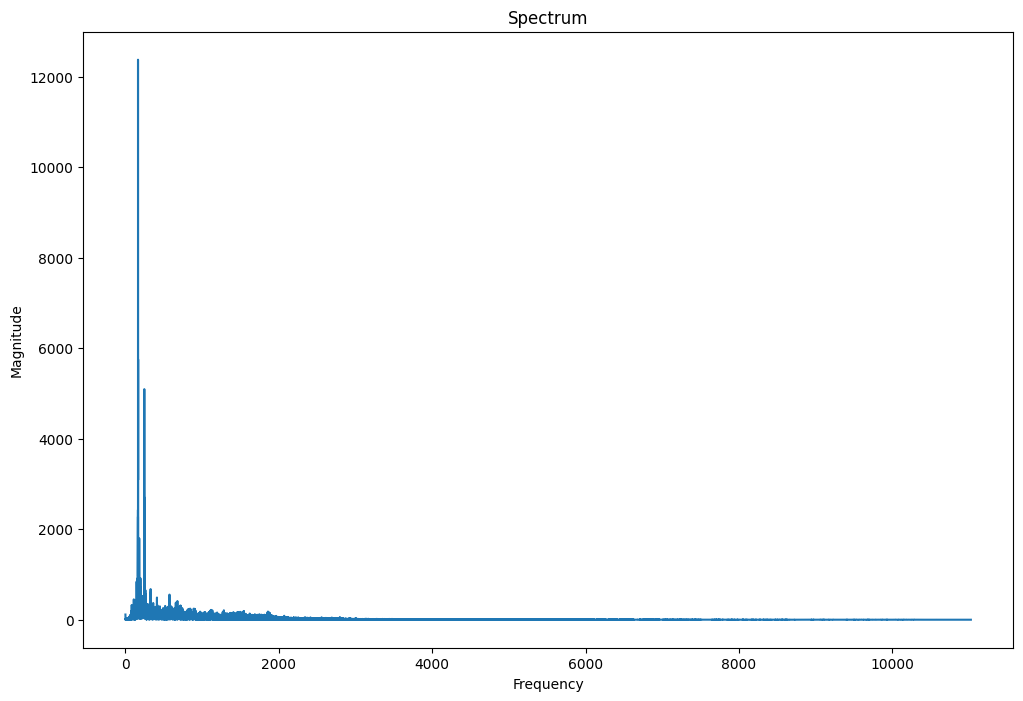

In [36]:
show_audio_spectrum(artifact_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


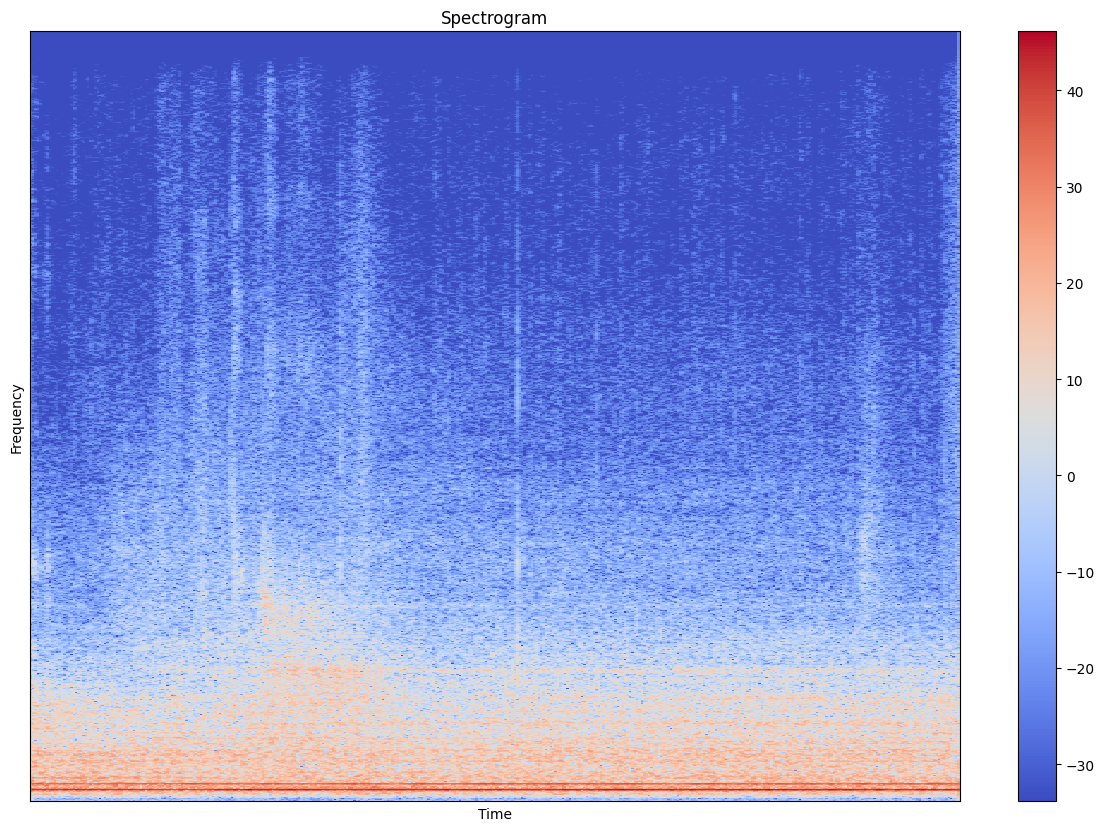

In [37]:
show_spectrogram(artifact_sample)

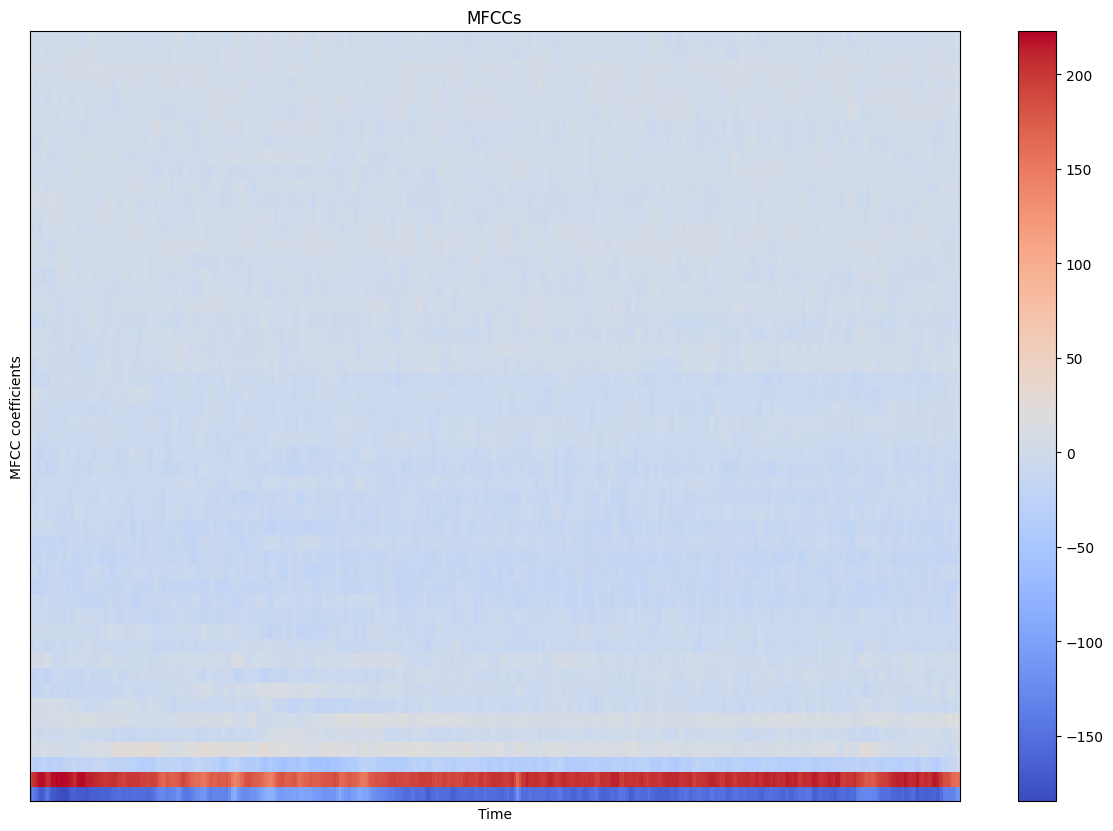

In [38]:
show_mfcc_features(artifact_sample)

### *5. Extrahls sound*

Extra heart sounds can be identified because there is an
additional sound, e.g. a “lub-lub dub” or a “lub dub-dub”.

In [39]:
extrahls_audio, extrahls_sample  = random_sound(extrahls_data)
extrahls_audio

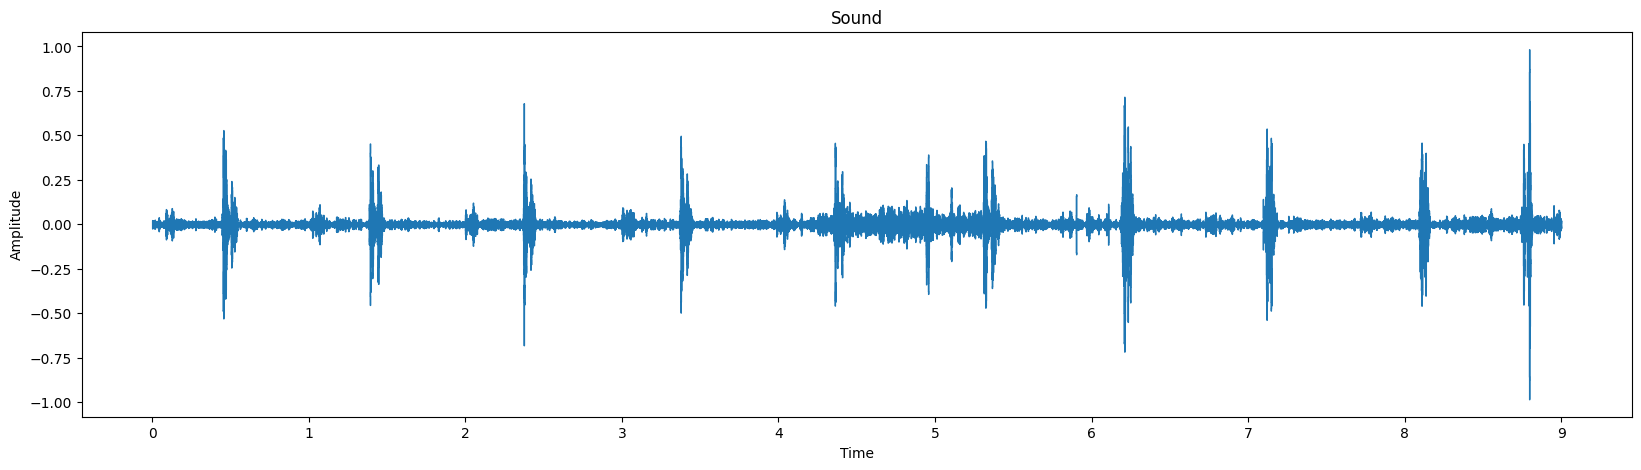

In [40]:
show_audio_waveform(extrahls_sample)

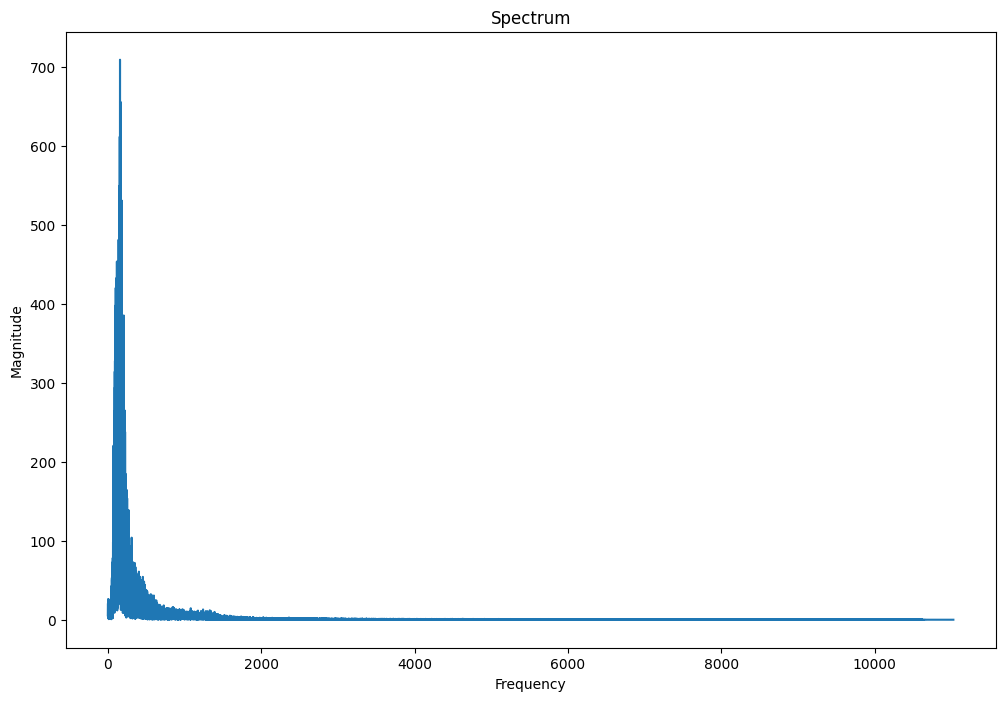

In [41]:
show_audio_spectrum(extrahls_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


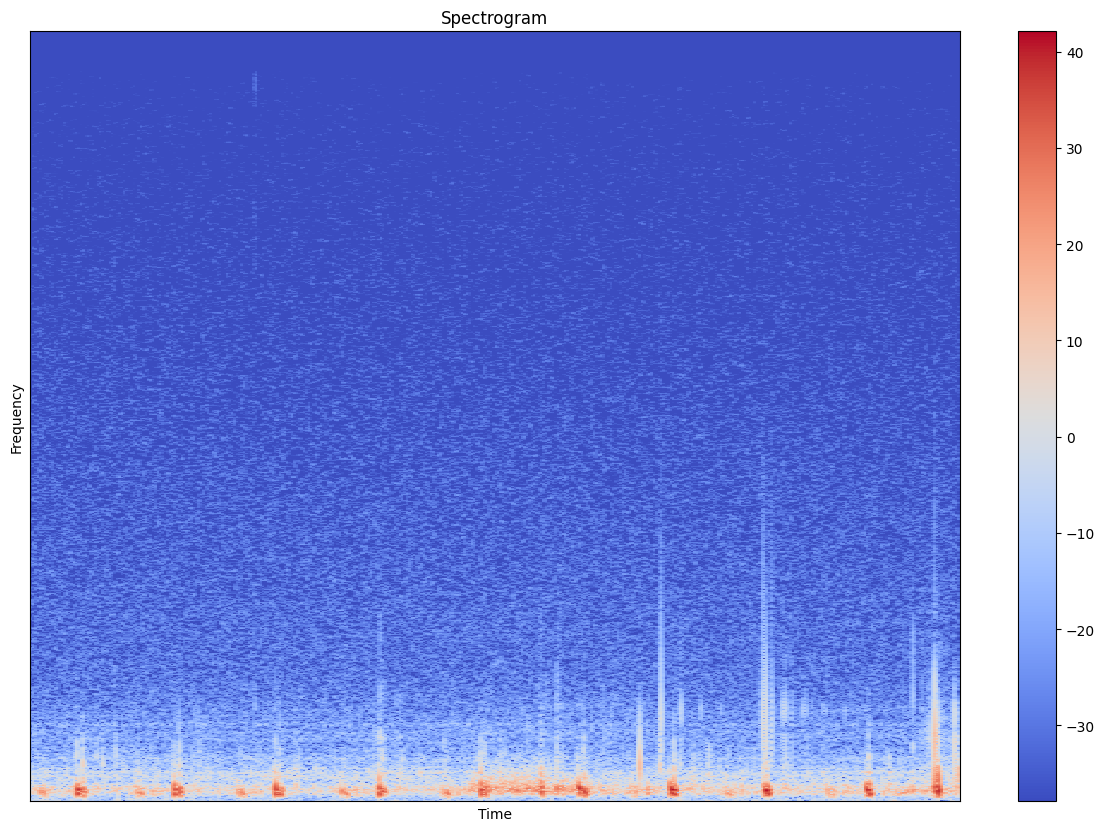

In [42]:
show_spectrogram(extrahls_sample)

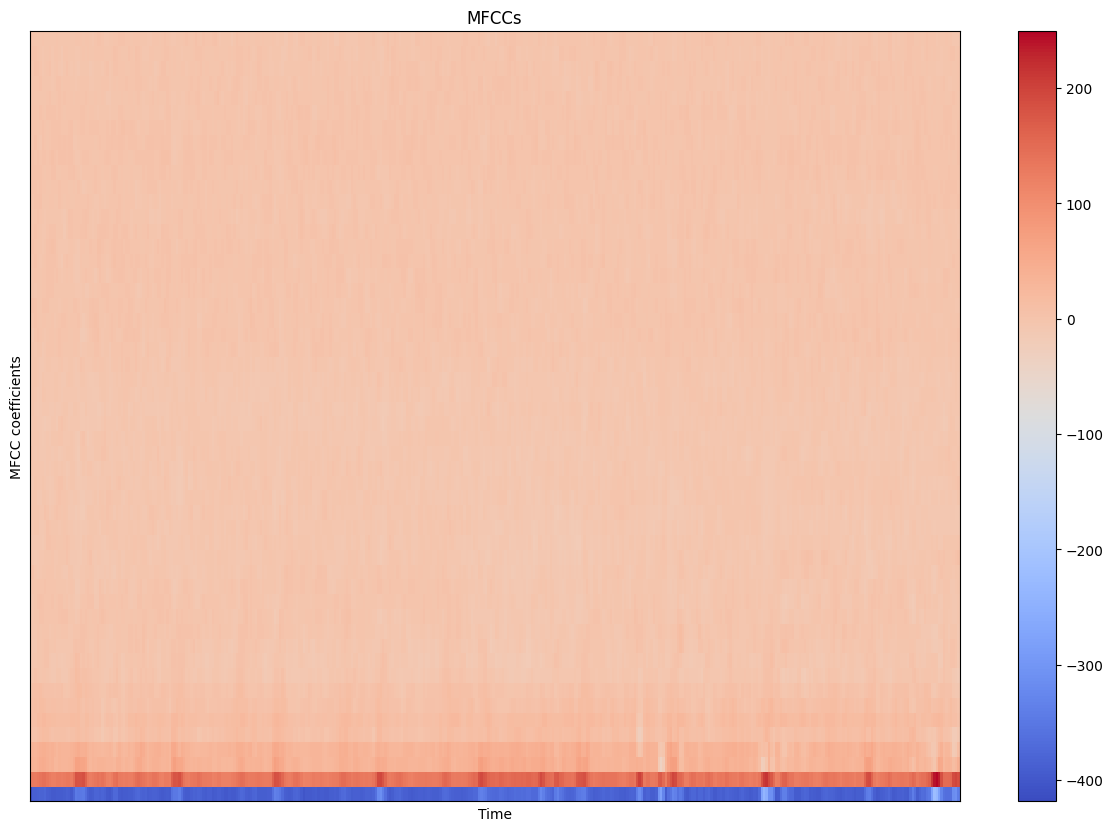

In [43]:
show_mfcc_features(extrahls_sample)

# Data Preprocessing

In [53]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    return librosa.effects.time_stretch(y=data, rate=rate)

def pitch_shift(data, rate, sr=22050):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=rate)


```
        Extract MFCC feature from the Sound data from the audio data.
        Augmentation of sound data by adding Noise, streaching and shifting.
        52 features are extracted from each audio data and used to train the model.

        Args:
            dir_: Input directory to the Sound input file.

        Returns:
            data: list of features extracted from the sound file.
```

In [51]:
def load_file_data(folder, file_names, duration=10, sr=22050):
    input_length = sr * duration
    features = 52
    data = []

    for file_name in file_names:
        try:
            sound_file = folder + file_name
            X, sr = librosa.load(sound_file, sr=sr, duration=duration)
            dur = librosa.get_duration(y=X, sr=sr)

            # pad audio file to same duration
            if round(dur) < duration:
                print("fixing audio length:", file_name)
                X = librosa.util.fix_length(data=X, size=input_length)

            # original MFCC
            mfccs = np.mean(librosa.feature.mfcc(
                y=X, sr=sr, n_mfcc=features).T, axis=0)
            data.append(mfccs.reshape([-1, 1]))

            # stretch 0.8
            stretch_1 = stretch(X, 0.8)
            mfcc_1 = np.mean(librosa.feature.mfcc(
                y=stretch_1, sr=sr, n_mfcc=features).T, axis=0)
            data.append(mfcc_1.reshape([-1, 1]))

            # stretch 1.2
            stretch_2 = stretch(X, 1.2)
            mfcc_2 = np.mean(librosa.feature.mfcc(
                y=stretch_2, sr=sr, n_mfcc=features).T, axis=0)
            data.append(mfcc_2.reshape([-1, 1]))

        except Exception as e:
            print("Error encountered while parsing file:", file_name, "=>", e)

    return data


## Encoding

In [46]:
# simple encoding of categories, convert to only 3 types:
# Normal (Include extrahls and extrastole)
# Murmur
# Artifact

# Map label text to integer
CLASSES = ['artifact','murmur','normal']
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'artifact': 0, 'murmur': 1, 'normal': 2}
 
{0: 'artifact', 1: 'murmur', 2: 'normal'}


## Data Augmenation and Feature Extraction

In [54]:
# 22 KHz
SAMPLE_RATE = 22050
# 10 seconds
MAX_SOUND_CLIP_DURATION=10

artifact_files = fnmatch.filter(os.listdir(artifact_data), 'artifact*.wav')
artifact_sounds = load_file_data (folder=artifact_data, file_names = artifact_files, duration=MAX_SOUND_CLIP_DURATION)
artifact_labels = [0 for items in artifact_sounds]

normal_files = fnmatch.filter(os.listdir(normal_data), 'normal*.wav')
normal_sounds = load_file_data(folder=normal_data,file_names=normal_files, duration=MAX_SOUND_CLIP_DURATION)
normal_labels = [2 for items in normal_sounds]

extrahls_files = fnmatch.filter(os.listdir(extrahls_data), 'extrahls*.wav')
extrahls_sounds = load_file_data(folder=extrahls_data,file_names=extrahls_files, duration=MAX_SOUND_CLIP_DURATION)
extrahls_labels = [2 for items in extrahls_sounds]

murmur_files = fnmatch.filter(os.listdir(murmur_data), 'murmur*.wav')
murmur_sounds = load_file_data(folder=murmur_data,file_names=murmur_files, duration=MAX_SOUND_CLIP_DURATION)
murmur_labels = [1 for items in murmur_sounds]


extrastole_files = fnmatch.filter(os.listdir(extrastole_data), 'extrastole*.wav')
extrastole_sounds = load_file_data(folder=extrastole_data,file_names=extrastole_files, duration=MAX_SOUND_CLIP_DURATION)
extrastole_labels = [2 for items in extrastole_sounds]

print ("Loading Done")


fixing audio length: artifact__201106131834.wav
fixing audio length: artifact__201106101955.wav
fixing audio length: artifact__201106220340.wav
fixing audio length: artifact__201105190800.wav
fixing audio length: artifact__201106040722.wav
fixing audio length: artifact__201106070949.wav
fixing audio length: artifact__201106221254.wav
fixing audio length: artifact__201106010602.wav
fixing audio length: artifact__201106021541.wav
fixing audio length: artifact__201106010559.wav
fixing audio length: artifact__201105061143.wav
fixing audio length: artifact__201106110909.wav
fixing audio length: artifact__201106161219.wav
fixing audio length: artifact__201105040918.wav
fixing audio length: artifact__201106211041.wav
fixing audio length: artifact__201106211430.wav
fixing audio length: artifact__201105280851.wav
fixing audio length: artifact__201105051017.wav
fixing audio length: artifact__201106131835.wav
fixing audio length: artifact__201106050353.wav
fixing audio length: artifact__201106141

In [55]:
# unlabel_datala files
Bunlabelledtest_files = fnmatch.filter(os.listdir(unlabel_data), 'Bunlabelledtest*.wav')
Bunlabelledtest_sounds = load_file_data(folder=unlabel_data,file_names=Bunlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
Bunlabelledtest_labels = [-1 for items in Bunlabelledtest_sounds]

Aunlabelledtest_files = fnmatch.filter(os.listdir(unlabel_data), 'Aunlabelledtest*.wav')
Aunlabelledtest_sounds = load_file_data(folder=unlabel_data,file_names=Aunlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
Aunlabelledtest_labels = [-1 for items in Aunlabelledtest_sounds]


print ("Loading of unlabel data done")


fixing audio length: Bunlabelledtest__231_1308748318393_C.wav
fixing audio length: Bunlabelledtest__152_1306779561195_C.wav
fixing audio length: Bunlabelledtest__235_1308749032454_C1.wav
fixing audio length: Bunlabelledtest__107_1305654946865_B.wav
fixing audio length: Bunlabelledtest__148_1306768801551_D.wav
fixing audio length: Bunlabelledtest__171_1307971016233_F.wav
fixing audio length: Bunlabelledtest__169_1307970398039_C1.wav
fixing audio length: Bunlabelledtest__148_1306768801551_A.wav
fixing audio length: Bunlabelledtest__179_1307990076841_D1.wav
fixing audio length: Bunlabelledtest__159_1307018640315_C.wav
fixing audio length: Bunlabelledtest__300_1311772096120_D.wav
fixing audio length: Bunlabelledtest__151_1306779785624_A1.wav
fixing audio length: Bunlabelledtest__181_1308052613891_C.wav
fixing audio length: Bunlabelledtest__174_1307987737137_C.wav
fixing audio length: Bunlabelledtest__286_1311170606028_B.wav
fixing audio length: Bunlabelledtest__175_1307987962616_C.wav
fixi

## Concatenation

In [56]:
#combine set-a and set-b
x_data = np.concatenate((artifact_sounds, normal_sounds,extrahls_sounds,murmur_sounds,extrastole_sounds))

y_data = np.concatenate((artifact_labels, normal_labels,extrahls_labels,murmur_labels,extrastole_labels))

test_x = np.concatenate((Aunlabelledtest_sounds,Bunlabelledtest_sounds))
test_y = np.concatenate((Aunlabelledtest_labels,Bunlabelledtest_labels))

print ("combined training data record: ",len(y_data), len(test_y))

combined training data record:  1755 741


## Data Split


In [57]:
# shuffle - whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.

# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=42, shuffle=True)

# One-Hot encoding for classes
y_train = np.array(tf.keras.utils.to_categorical(y_train, len(CLASSES)))
y_test = np.array(tf.keras.utils.to_categorical(y_test, len(CLASSES)))
y_val = np.array(tf.keras.utils.to_categorical(y_val, len(CLASSES)))
test_y=np.array(tf.keras.utils.to_categorical(test_y, len(CLASSES)))

## Correct Imbalnced Data

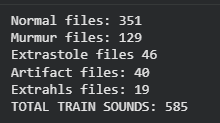

In [58]:
# class weight
TRAIN_IMG_COUNT = 578
COUNT_0 = 40  #artifact
COUNT_1 = 129 #murmur
COUNT_2 = 409 #normal
weight_for_0 = TRAIN_IMG_COUNT / (3 * COUNT_0)
weight_for_1 = TRAIN_IMG_COUNT / (3 * COUNT_1)
weight_for_2 = TRAIN_IMG_COUNT / (3 * COUNT_2)
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}
class_weight

{0: 4.816666666666666, 1: 1.4935400516795865, 2: 0.4710676446617767}

# LSTM Model

In [59]:
x_train_lstm = x_train
x_val_lstm = x_test
x_test_lstm = x_val

y_train_lstm = y_train
y_val_lstm = y_test
y_test_lstm = y_val

## Build Model

In [60]:
lstm_model = Sequential([
    tf.keras.layers.Input(shape=(52, 1)),

    Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    BatchNormalization(),

    Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    BatchNormalization(),

    Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    BatchNormalization(),

    LSTM(256, return_sequences=True),
    LSTM(128),

    Dense(64, activation='relu'),
    Dropout(0.5),

    Dense(32, activation='relu'),
    Dropout(0.5),

    Dense(3, activation='softmax')
])

lstm_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 52, 2048)       │        12,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 26, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 2048)       │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 26, 1024)       │    10,486,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 13, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 1024)       │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 13, 512)        │     2,621,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 7, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 7, 256)         │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,130,371 (53.90 MB)

 Trainable params: 14,123,203 (53.88 MB)

 Non-trainable params: 7,168 (28.00 KB)

In [61]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)

lstm_model.compile(
    optimizer = optimiser,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

cb = [
    EarlyStopping(
        patience = 20,
        monitor = 'val_accuracy',
        mode = 'max',
        restore_best_weights = True
    ),

    ModelCheckpoint(
        "/content/heart_beat_checkpoint/Heart_LSTM_CNN_1.h5",
        save_best_only = True
    )
]

## Train Model

In [62]:
history = lstm_model.fit(x_train_lstm, y_train_lstm,
                         validation_data=(x_val_lstm, y_val_lstm),
                         batch_size=8, epochs=250,
                         class_weight=class_weight,callbacks = cb )

Epoch 1/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5447 - loss: 0.9926

158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.5450 - loss: 0.9919 - val_accuracy: 0.5071 - val_loss: 0.8694
Epoch 2/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6271 - loss: 0.6859 - val_accuracy: 0.1966 - val_loss: 1.1541
Epoch 3/250
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5604 - loss: 0.7177

158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5603 - loss: 0.7172 - val_accuracy: 0.6325 - val_loss: 0.7652
Epoch 4/250
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5842 - loss: 0.7493

158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5842 - loss: 0.7483 - val_accuracy: 0.5698 - val_loss: 0.7541
Epoch 5/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5287 - loss: 0.6380 - val_accuracy: 0.6154 - val_loss: 0.7644
Epoch 6/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5635 - loss: 0.6390 - val_accuracy: 0.2279 - val_loss: 2.8524
Epoch 7/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5868 - loss: 0.6155 - val_accuracy: 0.2707 - val_loss: 0.7544
Epoch 8/250
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5730 - loss: 0.5294

158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5733 - loss: 0.5294 - val_accuracy: 0.2564 - val_loss: 0.7114
Epoch 9/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5920 - loss: 0.6044 - val_accuracy: 0.2393 - val_loss: 0.7700
Epoch 10/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5697 - loss: 0.5465 - val_accuracy: 0.5556 - val_loss: 0.7390
Epoch 11/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.5704 - loss: 0.5378 - val_accuracy: 0.2735 - val_loss: 0.7343
Epoch 12/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.5836 - loss: 0.5125 - val_accuracy: 0.4530 - val_loss: 0.7288
Epoch 13/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5967 - loss: 0.4927 - val_accuracy: 0.3932 - val_loss: 0.8039
Epoch 14/250
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6726 - loss: 0.4713

158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6725 - loss: 0.4716 - val_accuracy: 0.6268 - val_loss: 0.6810
Epoch 15/250
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6636 - loss: 0.4698

158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.6636 - loss: 0.4697 - val_accuracy: 0.7037 - val_loss: 0.6763
Epoch 16/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7182 - loss: 0.4263 - val_accuracy: 0.6125 - val_loss: 0.6971
Epoch 17/250
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6875 - loss: 0.4758

158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.6878 - loss: 0.4756 - val_accuracy: 0.7863 - val_loss: 0.5962
Epoch 18/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7427 - loss: 0.4574 - val_accuracy: 0.7749 - val_loss: 0.6226
Epoch 19/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7338 - loss: 0.4676 - val_accuracy: 0.1795 - val_loss: 5.4155
Epoch 20/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6634 - loss: 0.6068 - val_accuracy: 0.7436 - val_loss: 0.6087
Epoch 21/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6976 - loss: 0.4563 - val_accuracy: 0.7293 - val_loss: 0.6084
Epoch 22/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6998 - loss: 0.4290 - val_accuracy: 0.8205 - val_loss: 0.6155
Epoch 23/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7175 - loss: 0.4373 - val_accuracy: 0.7977 - val_loss: 0.6173
Epoch 24/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7419 - loss: 0.4762 - val_a

158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.6910 - loss: 0.4752 - val_accuracy: 0.8291 - val_loss: 0.5718
Epoch 26/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7610 - loss: 0.4246 - val_accuracy: 0.8148 - val_loss: 0.6177
Epoch 27/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7288 - loss: 0.4495 - val_accuracy: 0.5442 - val_loss: 0.8367
Epoch 28/250
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7407 - loss: 0.4359

158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7406 - loss: 0.4358 - val_accuracy: 0.7806 - val_loss: 0.5668
Epoch 29/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7099 - loss: 0.4712 - val_accuracy: 0.7322 - val_loss: 0.6475
Epoch 30/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.7649 - loss: 0.3932 - val_accuracy: 0.7322 - val_loss: 0.6642
Epoch 31/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.7495 - loss: 0.4102 - val_accuracy: 0.6923 - val_loss: 0.7777
Epoch 32/250
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7607 - loss: 0.4174

158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.7605 - loss: 0.4172 - val_accuracy: 0.8177 - val_loss: 0.5397
Epoch 33/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7540 - loss: 0.4452 - val_accuracy: 0.3447 - val_loss: 1.0524
Epoch 34/250
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7478 - loss: 0.4235

158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7480 - loss: 0.4233 - val_accuracy: 0.8148 - val_loss: 0.5315
Epoch 35/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7721 - loss: 0.4078 - val_accuracy: 0.6581 - val_loss: 0.6653
Epoch 36/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7422 - loss: 0.4115 - val_accuracy: 0.8575 - val_loss: 0.5559
Epoch 37/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8000 - loss: 0.3845 - val_accuracy: 0.8063 - val_loss: 0.6237
Epoch 38/250
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8148 - loss: 0.4272

158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.8148 - loss: 0.4270 - val_accuracy: 0.8405 - val_loss: 0.5262
Epoch 39/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7807 - loss: 0.4294 - val_accuracy: 0.7778 - val_loss: 0.6063
Epoch 40/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7900 - loss: 0.3750 - val_accuracy: 0.6838 - val_loss: 0.6267
Epoch 41/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8004 - loss: 0.3459 - val_accuracy: 0.7977 - val_loss: 0.5582
Epoch 42/250
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8173 - loss: 0.3597

158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8171 - loss: 0.3599 - val_accuracy: 0.8348 - val_loss: 0.5228
Epoch 43/250
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7839 - loss: 0.3895

158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7840 - loss: 0.3893 - val_accuracy: 0.8547 - val_loss: 0.5087
Epoch 44/250
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8360 - loss: 0.4256

158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8359 - loss: 0.4252 - val_accuracy: 0.8490 - val_loss: 0.5052
Epoch 45/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8245 - loss: 0.3470 - val_accuracy: 0.6125 - val_loss: 0.6522
Epoch 46/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8199 - loss: 0.3204 - val_accuracy: 0.5954 - val_loss: 0.8871
Epoch 47/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8041 - loss: 0.5388 - val_accuracy: 0.7578 - val_loss: 0.6048
Epoch 48/250
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8625 - loss: 0.2944

158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8623 - loss: 0.2948 - val_accuracy: 0.8547 - val_loss: 0.4278
Epoch 49/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8394 - loss: 0.3305 - val_accuracy: 0.8490 - val_loss: 0.4628
Epoch 50/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7883 - loss: 0.4444 - val_accuracy: 0.7949 - val_loss: 0.6789
Epoch 51/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8538 - loss: 0.3446 - val_accuracy: 0.5356 - val_loss: 0.8064
Epoch 52/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8590 - loss: 0.2905 - val_accuracy: 0.8718 - val_loss: 0.4878
Epoch 53/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8492 - loss: 0.3105 - val_accuracy: 0.8547 - val_loss: 0.4365
Epoch 54/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8705 - loss: 0.2576 - val_accuracy: 0.8632 - val_loss: 0.4324
Epoch 55/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8658 - loss: 0.2801 - val_a

158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8202 - loss: 0.3436 - val_accuracy: 0.8746 - val_loss: 0.3733
Epoch 59/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8585 - loss: 0.2682 - val_accuracy: 0.8291 - val_loss: 0.4402
Epoch 60/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8865 - loss: 0.2524 - val_accuracy: 0.3419 - val_loss: 0.9550
Epoch 61/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8602 - loss: 0.3182 - val_accuracy: 0.6724 - val_loss: 0.6482
Epoch 62/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8744 - loss: 0.2225 - val_accuracy: 0.7037 - val_loss: 0.6691
Epoch 63/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8633 - loss: 0.3006 - val_accuracy: 0.8462 - val_loss: 0.3963
Epoch 64/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8855 - loss: 0.2544 - val_accuracy: 0.7293 - val_loss: 0.5124
Epoch 65/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8874 - loss: 0.2070 - val_a

158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9133 - loss: 0.1781 - val_accuracy: 0.9031 - val_loss: 0.2944
Epoch 68/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9152 - loss: 0.2010 - val_accuracy: 0.8462 - val_loss: 0.3575
Epoch 69/250
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9241 - loss: 0.1690

158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9240 - loss: 0.1693 - val_accuracy: 0.8946 - val_loss: 0.2797
Epoch 70/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9358 - loss: 0.1710 - val_accuracy: 0.8917 - val_loss: 0.2928
Epoch 71/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9163 - loss: 0.1860 - val_accuracy: 0.9060 - val_loss: 0.2897
Epoch 72/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9222 - loss: 0.2194 - val_accuracy: 0.8433 - val_loss: 0.5523
Epoch 73/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9128 - loss: 0.1913 - val_accuracy: 0.8234 - val_loss: 0.5288
Epoch 74/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9017 - loss: 0.1895 - val_accuracy: 0.8661 - val_loss: 0.3806
Epoch 75/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9226 - loss: 0.1647 - val_accuracy: 0.9003 - val_loss: 0.3109
Epoch 76/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9087 - loss: 0.2294 - val_

158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9251 - loss: 0.1428 - val_accuracy: 0.9174 - val_loss: 0.2153
Epoch 80/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9614 - loss: 0.0923 - val_accuracy: 0.8832 - val_loss: 0.2806
Epoch 81/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9472 - loss: 0.1185 - val_accuracy: 0.6952 - val_loss: 0.6386
Epoch 82/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9412 - loss: 0.1046 - val_accuracy: 0.7094 - val_loss: 0.5579
Epoch 83/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9156 - loss: 0.1943 - val_accuracy: 0.8234 - val_loss: 0.3958
Epoch 84/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9295 - loss: 0.1576 - val_accuracy: 0.9202 - val_loss: 0.2934
Epoch 85/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9711 - loss: 0.0897 - val_accuracy: 0.7635 - val_loss: 0.6989
Epoch 86/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9438 - loss: 0.1180 - val_a

158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9733 - loss: 0.0739 - val_accuracy: 0.9402 - val_loss: 0.2134
Epoch 96/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9838 - loss: 0.0758 - val_accuracy: 0.9373 - val_loss: 0.2259
Epoch 97/250
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9770 - loss: 0.0555

158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9768 - loss: 0.0559 - val_accuracy: 0.9145 - val_loss: 0.2014
Epoch 98/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9475 - loss: 0.1512 - val_accuracy: 0.8832 - val_loss: 0.3238
Epoch 99/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9594 - loss: 0.0931 - val_accuracy: 0.8946 - val_loss: 0.2702
Epoch 100/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9558 - loss: 0.0717 - val_accuracy: 0.7778 - val_loss: 0.7141
Epoch 101/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9489 - loss: 0.0919 - val_accuracy: 0.8632 - val_loss: 0.4088
Epoch 102/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9613 - loss: 0.0772 - val_accuracy: 0.9231 - val_loss: 0.2599
Epoch 103/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9762 - loss: 0.0736 - val_accuracy: 0.8832 - val_loss: 0.4190
Epoch 104/250
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9479 - loss: 0.1053 - 

## Evaluate Model

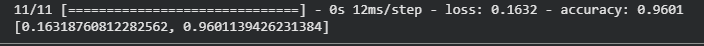

pre res above

In [63]:
lstm_model.evaluate(x_val_lstm, y_val_lstm)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9531 - loss: 0.1979


[0.21344558894634247, 0.94017094373703]

prev res

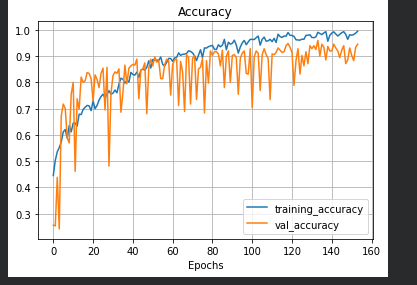

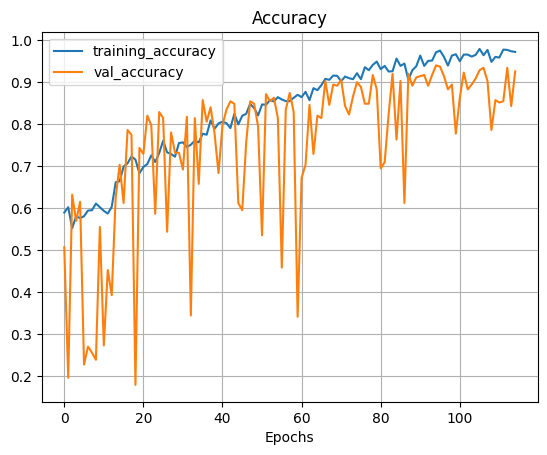

In [64]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
#   plt.plot(epochs, loss, label='training_loss')
#   plt.plot(epochs, val_loss, label='val_loss')
#   plt.title('Loss')
#   plt.xlabel('Epochs')
#   plt.legend()
#   plt.grid()


  # Plot accuracy
  plt.figure()
  plt.grid()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(history)

## Results

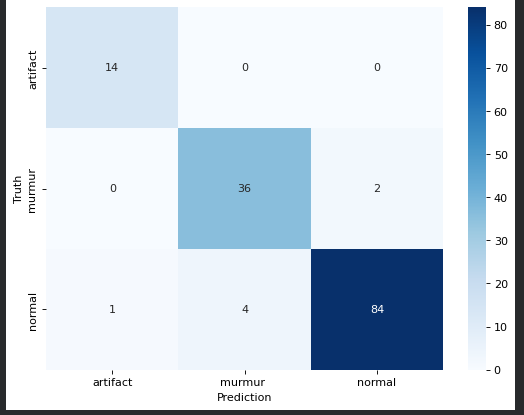

prev res

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


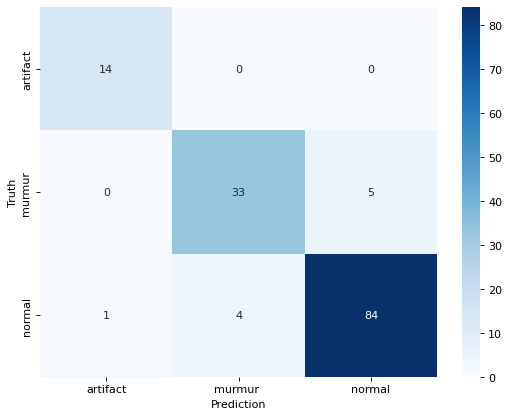

In [65]:

classes = ["artifact" ,"murmur ", "normal"]

preds = lstm_model.predict(x_test_lstm)
classpreds = [ np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in y_test_lstm]
cm = confusion_matrix(y_testclass, classpreds)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

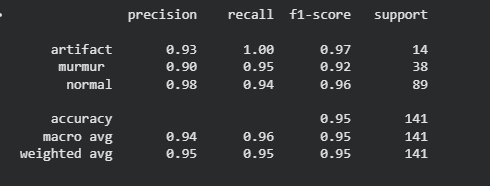

In [66]:
print(classification_report(y_testclass, classpreds, target_names=classes))

              precision    recall  f1-score   support

    artifact       0.93      1.00      0.97        14
     murmur        0.89      0.87      0.88        38
      normal       0.94      0.94      0.94        89

    accuracy                           0.93       141
   macro avg       0.92      0.94      0.93       141
weighted avg       0.93      0.93      0.93       141



prev res

## Prediction

In [72]:
def heart_prediction(file_path, duration=10, sr=22050):
    classes = ["artifact", "murmur", "normal"]
    input_length = sr * duration

    # Load audio
    X, sr = librosa.load(file_path, sr=sr, duration=duration)
    dur = librosa.get_duration(y=X, sr=sr)

    # Fix length (new librosa API)
    if round(dur) < duration:
        X = librosa.util.fix_length(data=X, size=input_length)

    # Extract MFCC
    mfccs = np.mean(
        librosa.feature.mfcc(
            y=X,
            sr=sr,
            n_mfcc=52,
            n_fft=512,
            hop_length=2048
        ).T,
        axis=0
    )

    mfcc_input = mfccs.reshape(1, 52, 1)

    # Predict
    raw_pred = lstm_model.predict(mfcc_input)

    pred_class = classes[np.argmax(raw_pred)]
    confidence = float(np.max(raw_pred))

    return pred_class, confidence


TEST

In [73]:
file_path = "/content/d.wav"  # change this to your file
pred, conf = heart_prediction(file_path)
print("Prediction:", pred)
print("Confidence:", conf)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Prediction: murmur
Confidence: 0.6321722865104675


In [69]:
# Save the trained model in HDF5 (.h5) format
# lstm_model.save("lstm_model.h5")
lstm_model.save("lstm_model.keras")

print("✅ Model saved successfully as lstm_model.h5")


✅ Model saved successfully as lstm_model.h5
